# импорт библиотек

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
import json
import pickle
import os

# функция для сохранения результатов

In [14]:
def save_arima_results(results_dict, best_model_name, forecasts, test_data, test_dates, train_data, ts_data, filename="arima_results.json"):
    """
    сохраняет результаты ARIMA моделей в json файл
    """
    results_to_save = {
        'best_model': best_model_name,
        'models_comparison': {},
        'forecasts': {},
        'test_data_info': {}
    }
    
    # сохраняем метрики для всех моделей
    for model_name, res in results_dict.items():
        if res is not None:
            results_to_save['models_comparison'][model_name] = {
                'rmse': float(res['rmse']),
                'mae': float(res['mae']),
                'mape': float(res['mape']),
                'mse': float(res['mse']),
                'aic': float(res['aic']),
                'bic': float(res['bic'])
            }
    
    # сохраняем прогнозы лучшей модели
    if best_model_name in forecasts and forecasts[best_model_name] is not None:
        # используем test_dates для дат прогнозов
        if hasattr(test_dates, 'strftime'):
            dates_list = test_dates.strftime('%Y-%m-%d %H:%M:%S').tolist()
        else:
            # если test_dates не DatetimeIndex, создаем список строк
            dates_list = [str(date) for date in test_dates]
            
        results_to_save['forecasts'][best_model_name] = {
            'dates': dates_list,
            'values': forecasts[best_model_name].values.tolist()
        }
    
    # сохраняем информацию о тестовых данных
    results_to_save['test_data_info'] = {
        'train_size': len(train_data),
        'test_size': len(test_data),
        'data_period': f"{ts_data.index.min()} до {ts_data.index.max()}",
        'train_period': f"{train_data.index.min()} до {train_data.index.max()}" if hasattr(train_data.index, 'min') else "недоступно",
        'test_period': f"{test_dates.min()} до {test_dates.max()}" if hasattr(test_dates, 'min') else "недоступно"
    }
    
    # сохраняем в json файл
    with open(filename, 'w') as f:
        json.dump(results_to_save, f, indent=4, ensure_ascii=False)
    
    print(f"\nрезультаты сохранены в файл: {filename}")
    
    return results_to_save

# загрузка и подготовка данных

In [15]:
# загружаем те же данные, что используются в LSTM модели
print("загрузка данных...")
data = pd.read_csv('bitcoin_2017_to_2023.csv')

# преобразуем timestamp в datetime и устанавливаем как индекс
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# для ARIMA нам нужен только временной ряд цены (возьмем 'low' как в LSTM моделях)
ts_data = data['low'].copy()

print("\n информация о временном ряде ")
print(f"размер временного ряда: {len(ts_data)}")
print(f"период данных: {ts_data.index.min()} до {ts_data.index.max()}")
print(f"частота данных: {pd.infer_freq(ts_data.index[:10])}")

загрузка данных...

 информация о временном ряде 
размер временного ряда: 3126000
период данных: 2017-08-17 04:00:00 до 2023-08-01 13:19:00
частота данных: -1min


# визуализация исходных данных

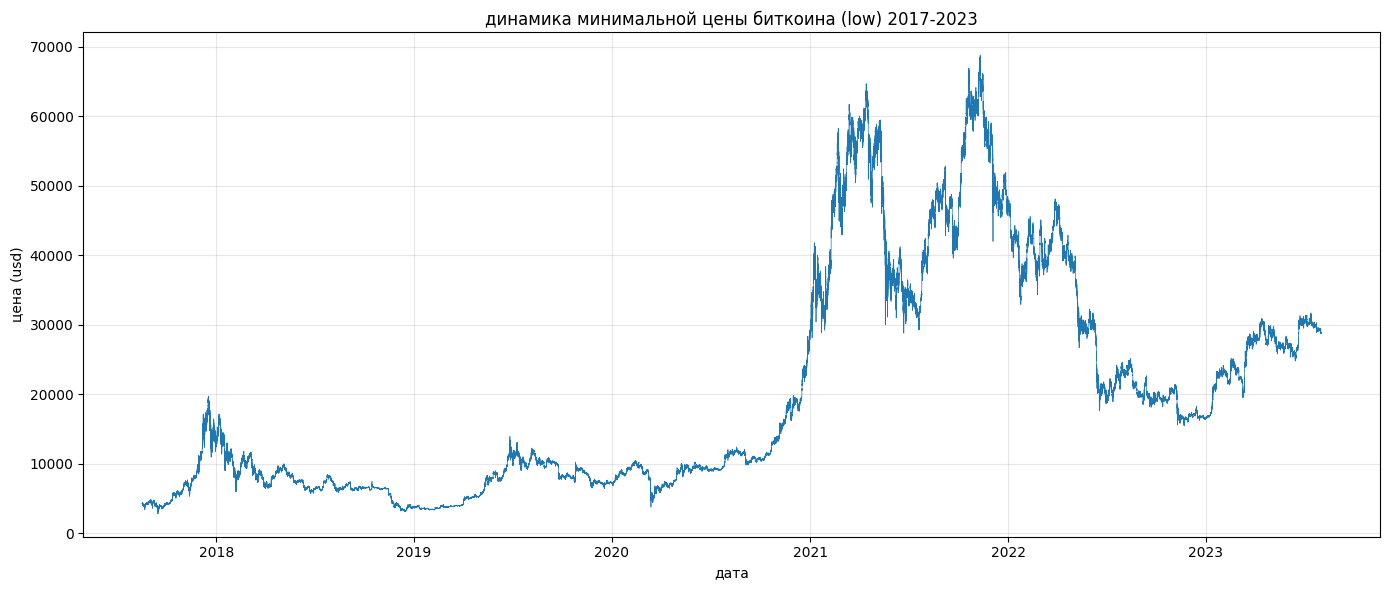

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(ts_data, linewidth=0.5)
plt.title('динамика минимальной цены биткоина (low) 2017-2023')
plt.xlabel('дата')
plt.ylabel('цена (usd)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# проверка стационарности

In [17]:
# для того, чтобы использовать ARIMA, необходим стационарный временной ряд
# по сути, стоимость криптовалюты не является таким, потому что имеет места с явным ростом или падением
# может зависеть от событий в мире, например, из-за чего также будет наблюдаться изменение среднего значения со временем
# в статье об этом ничего нет

# def check_stationarity(timeseries):
#     """проверяет стационарность временного ряда с помощью теста дикки-фуллера"""
#     result = adfuller(timeseries.dropna())
#     print('результаты теста дикки-фуллера:')
#     print(f'статистика: {result[0]:.4f}')
#     print(f'p-value: {result[1]:.4f}')
    
#     if result[1] <= 0.05:
#         print("вывод: ряд стационарен (p-value ≤ 0.05)")
#         return True
#     else:
#         print("вывод: ряд нестационарен (p-value > 0.05)")
#         return False

# print("\n проверка стационарности исходного ряда ")
# is_stationary = check_stationarity(ts_data)

# подготовка данных для ARIMA

In [18]:
arima_sample_size = 50000
ts_data_subset = data['low'].iloc[-arima_sample_size:].copy()

ts_data_subset = ts_data_subset.iloc[::-1].copy()

original_dates = ts_data_subset.index.copy()

print(f"\n подготовка выборки для ARIMA ")
print(f"размер выборки для ARIMA: {len(ts_data_subset)} записей")
print(f"даты выборки: {original_dates.min()} до {original_dates.max()}")

# разделяем на обучающую и тестовую выборки
# используем 80% для обучения, 20% для тестирования
total_size = len(ts_data_subset)
train_size = int(total_size * 0.8)
test_size = total_size - train_size

train_data = ts_data_subset.iloc[:train_size]
test_data = ts_data_subset.iloc[train_size:]

test_dates = original_dates[train_size:train_size + test_size]

print(f"обучающая выборка: {len(train_data)} записей")
print(f"тестовая выборка: {len(test_data)} записей")
print(f"даты обучения: {train_data.index.min()} до {train_data.index.max()}")
print(f"даты тестирования: {test_data.index.min()} до {test_data.index.max()}")


 подготовка выборки для ARIMA 
размер выборки для ARIMA: 50000 записей
даты выборки: 2017-08-17 04:00:00 до 2017-09-21 04:18:00
обучающая выборка: 40000 записей
тестовая выборка: 10000 записей
даты обучения: 2017-08-17 04:00:00 до 2017-09-14 05:38:00
даты тестирования: 2017-09-14 05:39:00 до 2017-09-21 04:18:00


# реализация ARIMA моделей из статьи 

In [19]:
# в статье тестировались модели: ARIMA(1,1,1), (1,1,2), (2,1,0), (2,1,1), (2,1,2)
# наилучшей оказалась ARIMA(2,1,2)

arima_models = {
    'ARIMA(1,1,1)': (1, 1, 1),
    'ARIMA(1,1,2)': (1, 1, 2),
    'ARIMA(2,1,0)': (2, 1, 0),
    'ARIMA(2,1,1)': (2, 1, 1),
    'ARIMA(2,1,2)': (2, 1, 2)
}

results = {}
forecasts = {}

print("\n" + "="*70)
print("обучение ARIMA моделей:")
print("="*70)

for model_name, order in arima_models.items():
    print(f"\nобучение {model_name}...")
    try:
        # обучение модели
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        
        # прогноз на длину тестовой выборки
        forecast = model_fit.forecast(steps=len(test_data))
        
        # расчет метрик ошибки
        mse = mean_squared_error(test_data, forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test_data, forecast)
        mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
        
        # сохранение результатов
        results[model_name] = {
            'model': model_fit,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'mse': mse,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        }
        
        forecasts[model_name] = forecast
        
        print(f"  rmse: {rmse:.2f}")
        print(f"  mae: {mae:.2f}")
        print(f"  mape: {mape:.2f}%")
        print(f"  aic: {model_fit.aic:.2f}")
        
    except Exception as e:
        print(f"  ошибка при обучении {model_name}: {e}")
        results[model_name] = None
        forecasts[model_name] = None


обучение ARIMA моделей:

обучение ARIMA(1,1,1)...
  rmse: 276.57
  mae: 199.67
  mape: nan%
  aic: 321966.91

обучение ARIMA(1,1,2)...
  rmse: 277.05
  mae: 199.90
  mape: nan%
  aic: 321930.00

обучение ARIMA(2,1,0)...
  rmse: 276.22
  mae: 199.50
  mape: nan%
  aic: 322366.55

обучение ARIMA(2,1,1)...
  rmse: 276.89
  mae: 199.82
  mape: nan%
  aic: 321939.02

обучение ARIMA(2,1,2)...
  rmse: 277.18
  mae: 199.96
  mape: nan%
  aic: 321918.98


# сравнение точности ARIMA моделей

In [20]:
print("\n" + "="*70)
print("сравнение точности ARIMA моделей:")
print("="*70)

# создаем таблицу сравнения
comparison_data = []
for model_name, res in results.items():
    if res is not None:
        comparison_data.append({
            'Модель': model_name,
            'RMSE': res['rmse'],
            'MAE': res['mae'],
            'MAPE (%)': res['mape'],
            'AIC': res['aic']
        })

comparison_df = pd.DataFrame(comparison_data)

# сортируем по RMSE (чем меньше, тем лучше)
comparison_df = comparison_df.sort_values('RMSE')
print("\nранжирование моделей по точности (RMSE):")
print(comparison_df.to_string(index=False))

# определяем лучшую модель
best_arima_model = comparison_df.iloc[0]['Модель']
best_arima_metrics = results[best_arima_model]

print(f"\nлучшая ARIMA модель: {best_arima_model}")
print(f"метрики лучшей модели:")
print(f"  RMSE: {best_arima_metrics['rmse']:.2f}")
print(f"  MAE: {best_arima_metrics['mae']:.2f}")
print(f"  MAPE: {best_arima_metrics['mape']:.2f}%")
print(f"  AIC: {best_arima_metrics['aic']:.2f}")


сравнение точности ARIMA моделей:

ранжирование моделей по точности (RMSE):
      Модель       RMSE        MAE  MAPE (%)           AIC
ARIMA(2,1,0) 276.223892 199.502921       NaN 322366.545627
ARIMA(1,1,1) 276.569799 199.667387       NaN 321966.914405
ARIMA(2,1,1) 276.892417 199.821837       NaN 321939.022046
ARIMA(1,1,2) 277.046696 199.895581       NaN 321929.995793
ARIMA(2,1,2) 277.181581 199.959912       NaN 321918.976854

лучшая ARIMA модель: ARIMA(2,1,0)
метрики лучшей модели:
  RMSE: 276.22
  MAE: 199.50
  MAPE: nan%
  AIC: 322366.55


# сохранение результатов

In [21]:
# сохраняем результаты в файл
print("сохранение результатов:")


# создаем директорию для результатов, если её нет
os.makedirs('results50000', exist_ok=True)

# сохраняем все результаты
results_file = 'results50000/arima_results.json'
# передаем все необходимые данные в функцию
saved_results = save_arima_results(results, best_arima_model, forecasts, test_data, test_dates, train_data, ts_data, results_file)

# дополнительно сохраняем данные для сравнения в удобном формате
if hasattr(test_dates, 'strftime'):
    dates_list = test_dates.strftime('%Y-%m-%d %H:%M:%S').tolist()
else:
    # если test_dates не DatetimeIndex, создаем список строк
    dates_list = [str(date) for date in test_dates]

comparison_data = {
    'best_model': best_arima_model,
    'best_model_metrics': {
        'rmse': float(best_arima_metrics['rmse']),
        'mae': float(best_arima_metrics['mae']),
        'mape': float(best_arima_metrics['mape']),
        'mse': float(best_arima_metrics['mse']),
        'aic': float(best_arima_metrics['aic']),
        'bic': float(best_arima_metrics['bic'])
    },
    'all_models_metrics': comparison_df.to_dict('records'),
    'test_data': {
        'dates': dates_list,
        'actual_values': test_data.values.tolist(),
        'predicted_values': forecasts[best_arima_model].values.tolist() if best_arima_model in forecasts else []
    }
}

# сохраняем в отдельный файл для легкого доступа
with open('results50000/arima_comparison_data.json', 'w') as f:
    json.dump(comparison_data, f, indent=4, ensure_ascii=False)

print("данные для сравнения сохранены в: results50000/arima_comparison_data.json")

# также сохраняем в CSV для удобства
comparison_df.to_csv('results50000/arima_models_comparison.csv', index=False)
print("таблица сравнения сохранены в: results50000/arima_models_comparison.csv")

# сохраняем прогнозы лучшей модели
best_forecast = forecasts[best_arima_model] if best_arima_model in forecasts else None
if best_forecast is not None:
    forecast_df = pd.DataFrame({
        'date': test_dates,
        'actual': test_data.values,
        'predicted': best_forecast.values
    })
    forecast_df.to_csv('results50000/arima_best_forecast.csv', index=False)
    print("прогнозы лучшей модели сохранены в: results50000/arima_best_forecast.csv")

сохранение результатов:

результаты сохранены в файл: results50000/arima_results.json
данные для сравнения сохранены в: results50000/arima_comparison_data.json
таблица сравнения сохранены в: results50000/arima_models_comparison.csv
прогнозы лучшей модели сохранены в: results50000/arima_best_forecast.csv


# визуализация результатов

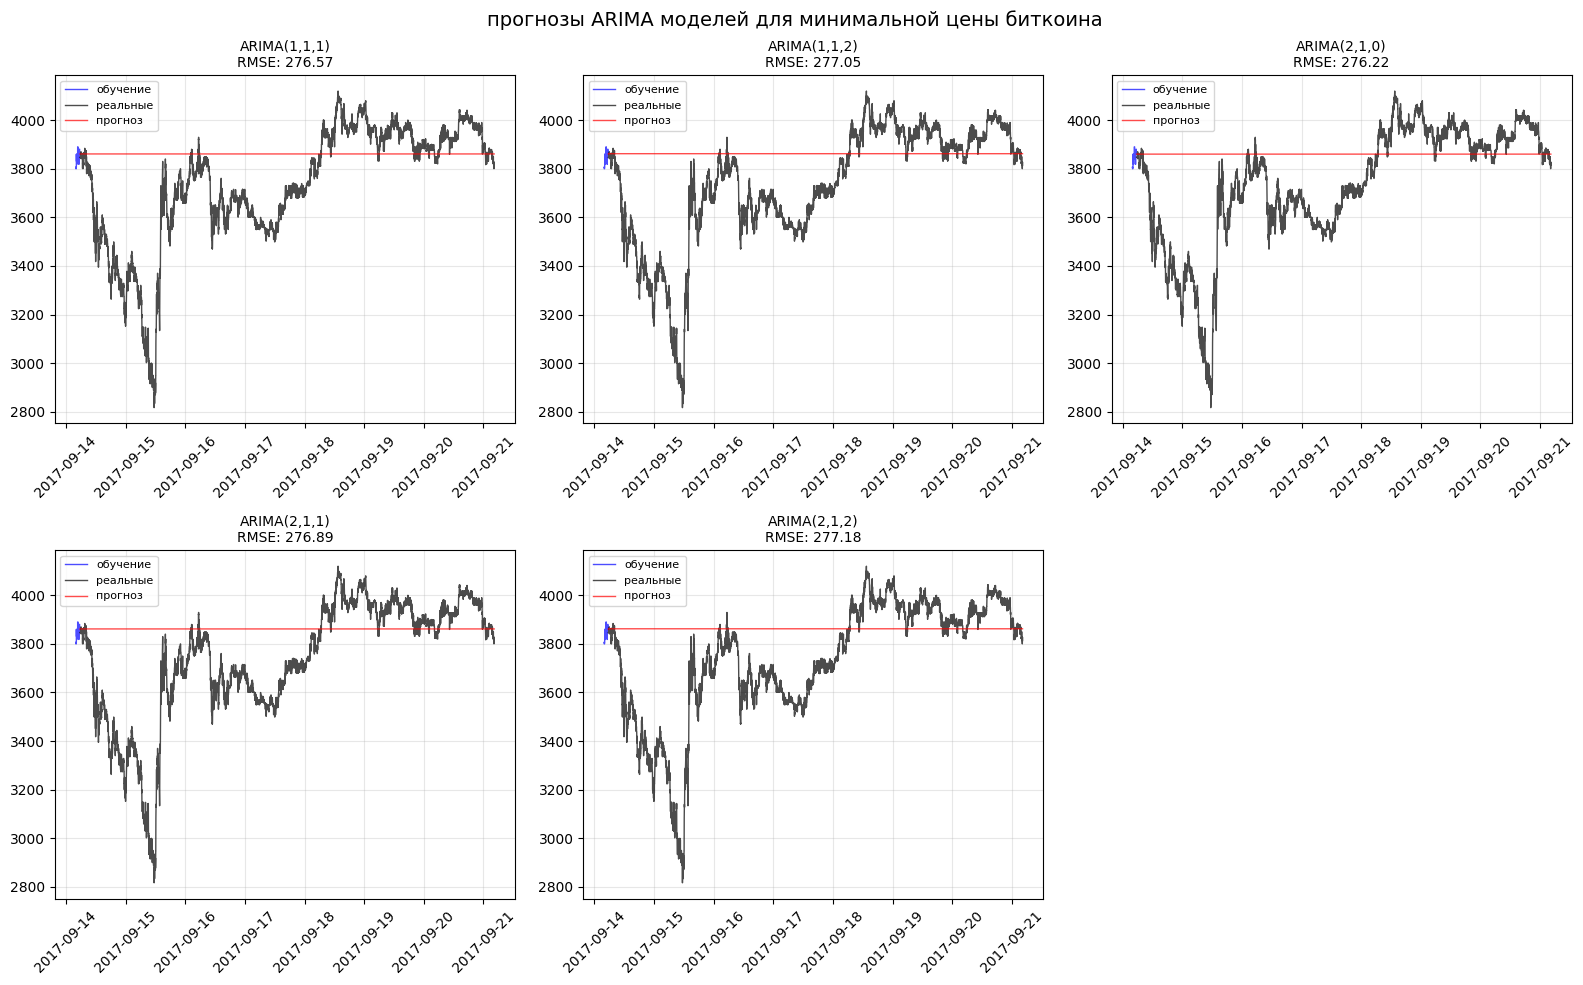

In [22]:
# графики прогнозов для всех моделей
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

plot_idx = 0
for idx, (model_name, forecast) in enumerate(forecasts.items()):
    if forecast is not None and plot_idx < 6:
        ax = axes[plot_idx]
        
        # отображаем последние 100 точек обучающих данных
        train_plot = train_data.iloc[-100:] if len(train_data) > 100 else train_data
        
        ax.plot(train_plot.index, train_plot.values, 'b-', label='обучение', alpha=0.7, linewidth=1)
        ax.plot(test_dates, test_data.values, 'k-', label='реальные', alpha=0.7, linewidth=1)
        ax.plot(test_dates, forecast.values, 'r-', label='прогноз', alpha=0.7, linewidth=1)
        
        rmse_val = results[model_name]['rmse']
        ax.set_title(f'{model_name}\nRMSE: {rmse_val:.2f}', fontsize=10)
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        plot_idx += 1

# скрываем пустые subplots
for idx in range(plot_idx, 6):
    fig.delaxes(axes[idx])

plt.suptitle('прогнозы ARIMA моделей для минимальной цены биткоина', fontsize=14)
plt.tight_layout()
plt.savefig('results50000/arima_models_forecasts.png', dpi=300, bbox_inches='tight')
plt.show()

# детальный график лучшей модели

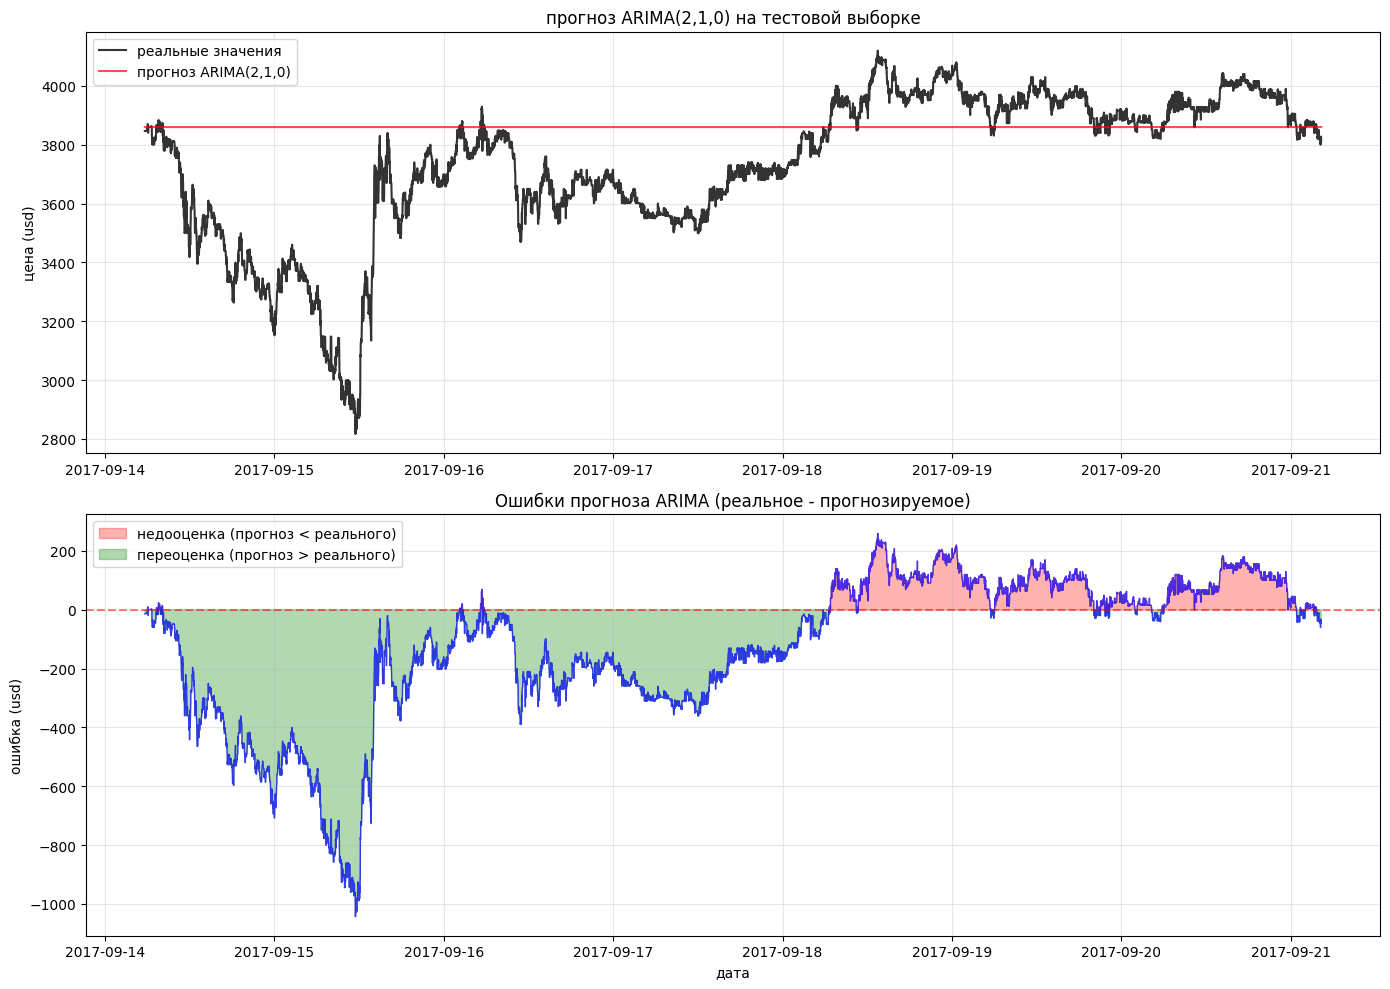

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# график 1: прогноз vs факт
ax1.plot(test_dates, test_data.values, 'k-', label='реальные значения', alpha=0.8, linewidth=1.5)
if best_arima_model in forecasts and forecasts[best_arima_model] is not None:
    ax1.plot(test_dates, forecasts[best_arima_model].values, 'r-', 
             label=f'прогноз {best_arima_model}', alpha=0.7, linewidth=1.5)
ax1.set_title(f'прогноз {best_arima_model} на тестовой выборке', fontsize=12)
ax1.set_ylabel('цена (usd)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# график 2: ошибки прогноза
if best_arima_model in forecasts and forecasts[best_arima_model] is not None:
    errors = test_data.values - forecasts[best_arima_model].values
    ax2.plot(test_dates, errors, 'b-', alpha=0.7, linewidth=1)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    ax2.fill_between(test_dates, 0, errors, 
                     where=errors >= 0, alpha=0.3, color='red', label='недооценка (прогноз < реального)')
    ax2.fill_between(test_dates, 0, errors, 
                     where=errors < 0, alpha=0.3, color='green', label='переоценка (прогноз > реального)')
    
    ax2.set_title('Ошибки прогноза ARIMA (реальное - прогнозируемое)', fontsize=12)
    ax2.set_xlabel('дата')
    ax2.set_ylabel('ошибка (usd)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results50000/arima_best_model_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

# выводы

In [24]:
print("выводы:")

print(f"\nлучшая модель ARIMA: {best_arima_model}")
print(f"   - RMSE: {best_arima_metrics['rmse']:.2f}")
print(f"   - MAE: {best_arima_metrics['mae']:.2f}")

выводы:

лучшая модель ARIMA: ARIMA(2,1,0)
   - RMSE: 276.22
   - MAE: 199.50
